<a href="https://colab.research.google.com/github/Sakshi-Singh2004/AIMLMonth2023/blob/main/Financial_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakshisingh2004","key":"f626c23ce1fe8ed0efe258138c0748b0"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d znevzz/the-news-dataset


Dataset URL: https://www.kaggle.com/datasets/znevzz/the-news-dataset
License(s): unknown
  0% 0.00/109M [00:00<?, ?B/s]
100% 109M/109M [00:00<00:00, 1.63GB/s]


In [7]:
!unzip -o the-news-dataset.zip


Archive:  the-news-dataset.zip
  inflating: README.md               
  inflating: data/README.md          
  inflating: data/explicit/company_keyword.xlsx  
  inflating: data/json/AX_sentiment.json  
  inflating: data/json/NSE-AX.json   
  inflating: data/json/NSE-REL.json  
  inflating: data/json/NSE-TCS.json  
  inflating: data/json/REL_sentiment.json  
  inflating: data/json/TCS_sentiment.json  
  inflating: data/processed/data_merged.csv  
  inflating: data/processed/data_o1.csv  
  inflating: data/processed/data_o2.csv  
  inflating: data/processed/data_o3.csv  
  inflating: data/processed/labeled.csv  
  inflating: data/processed/normalized.csv  
  inflating: data/quandl/NSE-AX.csv  
  inflating: data/quandl/NSE-REL.csv  
  inflating: data/quandl/NSE-TCS.csv  
  inflating: data/scrapy/livemint_data.csv  
  inflating: data/scrapy/livemint_data_2.csv  
  inflating: data/scrapy/livemint_data_3.csv  
  inflating: data/scrapy/livemint_data_body.csv  
  inflating: data/scrapy/livemint_

In [11]:
!find . -type f -name "*.csv"

./test/livemint_data_body_2.csv
./test/livemint_data.csv
./test/data_joined_2.csv
./test/REL_score_open.csv
./test/data_o1.csv
./test/REL_qs.csv
./test/NSE-TCS.csv
./test/REL.csv
./test/TCS_sentiment.csv
./test/TCS_score_close.csv
./test/REL_score_close.csv
./test/REL_corr.csv
./test/livemint_data_2.csv
./test/data_o2.csv
./test/livemint_data_body.csv
./test/TCS_score_open.csv
./test/TCS_qs.csv
./test/NSE-RELIANCE.csv
./test/REL_score.csv
./test/labeled_old_v1.csv
./test/normalized.csv
./test/REL_sentiment.csv
./test/TCS.csv
./test/data_o3.csv
./test/labeled.csv
./main/AX_qs.csv
./main/AX_score_open.csv
./main/REL_score_open.csv
./main/REL_qs.csv
./main/NSE-TCS.csv
./main/AX_score_close.csv
./main/NSE-REL.csv
./main/REL.csv
./main/TCS_sentiment.csv
./main/TCS_score_close.csv
./main/REL_score_close.csv
./main/TCS_score_open.csv
./main/TCS_qs.csv
./main/AX.csv
./main/REL_sentiment.csv
./main/TCS.csv
./main/NSE-AX.csv
./main/AX__sentiment.csv
./main/AX_sentiment.csv
./main/labeled.csv
./r

In [8]:
import pandas as pd

# Load labeled dataset (with sentiment scores)
labeled_df = pd.read_csv('data/processed/labeled.csv')

# Display the first few rows
print("Labeled Dataset:")
display(labeled_df.head())

Labeled Dataset:


,Unnamed: 0,body,date,id,intro,score,time,title
0,0,New Delhi: State-run Rural Electrification Cor...,2016-11-09,00wS6lZEcgYyCPt6mIXwrJ,"The company had posted a net profit of Rs1,61...",0.89,22:38,"REC net profit up 8% at Rs1,751 crore in July-..."
1,0,"Two sets of findings, related to societal trus...",2017-01-24,0229PSUGl9BxwsW7urHATP,The resulting trust deficit has had several di...,0.48,12:47,The consequences of declining trust in CEOs
2,0,Mumbai: The ministry of corporate affairs (MCA...,2016-11-15,02A1DgXR3wUC7xEX4UzqHN,Rejecting reasons cited for not spending on CS...,-0.14,02:13,MCA pulls up companies over lack of CSR spends
3,0,New Delhi: The central governments decision t...,2016-11-10,02xKYa7PKoROOpbx5xbxhM,"E-wallet companies like Paytm, Freecharge are ...",0.58,01:21,Demonetization to give major push to e-wallets...
4,0,"Pune: The 57-year-old boss of Tech Mahindra, C...",2016-12-21,05PcYpZOmBeSeBLoMPqETN,Tech Mahindra CEO CP Gurnani on bets his firm ...,-0.02,03:19,"By 2020, 50% of Tech Mahindras business will ..."


In [16]:
# Check basic info
print("Labeled Dataset Info:")
print(labeled_df.info())

# Check for missing values
print("\nMissing Values in Labeled Dataset:")
print(labeled_df.isnull().sum())

Labeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099 entries, 0 to 2098
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2099 non-null   int64  
 1   body        2089 non-null   object 
 2   date        2099 non-null   object 
 3   id          2099 non-null   object 
 4   intro       2099 non-null   object 
 5   score       2099 non-null   float64
 6   time        2099 non-null   object 
 7   title       2099 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 131.3+ KB
None

Missing Values in Labeled Dataset:
Unnamed: 0     0
body          10
date           0
id             0
intro          0
score          0
time           0
title          0
dtype: int64


In [17]:
# Drop the unnecessary column
labeled_df.drop(columns=['Unnamed: 0'], inplace=True)

# Fill missing 'body' values correctly to avoid warning
labeled_df.loc[:, 'body'] = labeled_df['body'].fillna(labeled_df['title'] + " " + labeled_df['intro'])

# Confirm there are no missing values now
print("\nMissing Values After Cleaning (Labeled Dataset):")
print(labeled_df.isnull().sum())


Missing Values After Cleaning (Labeled Dataset):
body     0
date     0
id       0
intro    0
score    0
time     0
title    0
dtype: int64


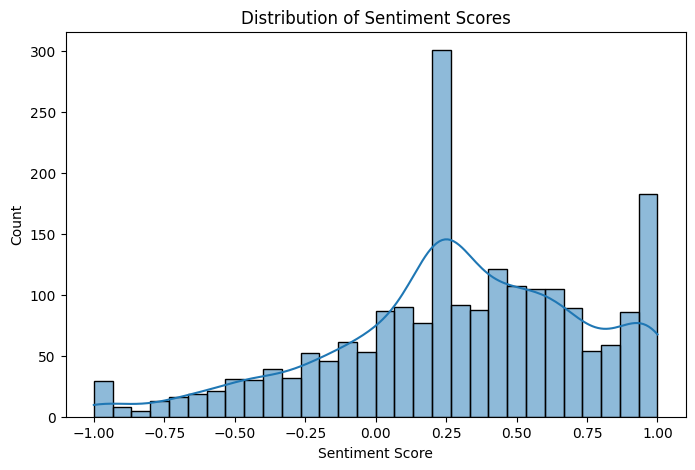

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment score distribution
plt.figure(figsize=(8, 5))
sns.histplot(labeled_df['score'], bins=30, kde=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')
plt.show()

sentiment_label
Positive    1367
Neutral      445
Negative     287
Name: count, dtype: int64


/tmp/ipython-input-710026248.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labeled_df['sentiment_label'], palette='viridis')


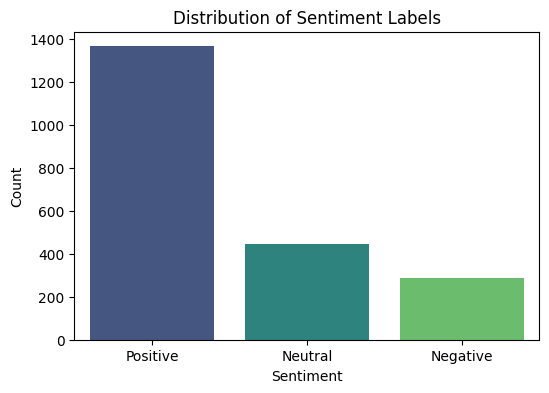

In [19]:
# Define sentiment categories
def classify_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

# Apply function to create a new sentiment label column
labeled_df['sentiment_label'] = labeled_df['score'].apply(classify_sentiment)

# Check the distribution of sentiment labels
print(labeled_df['sentiment_label'].value_counts())

# Visualizing sentiment label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=labeled_df['sentiment_label'], palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

In [1]:
!pip install --upgrade transformers datasets gcsfs fsspec

In [2]:
!pip uninstall torch torchvision torchaudio fastai -y
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 fastai

  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached fastai-2.8.4-py3-none-any.whl.metadata (9.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using ca

In [3]:
import transformers
import datasets
import torch
import torchvision
import torchaudio
import fastai

print(transformers.__version__)
print(torch.__version__)
print(torchvision.__version__)
print(torchaudio.__version__)
print(fastai.__version__)

4.57.1
2.6.0+cu124
0.21.0+cu124
2.6.0+cu124
2.8.4


In [4]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load FinBERT tokenizer & model
MODEL_NAME = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)  # 3 labels: Positive, Neutral, Negative

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [10]:
# Define sentiment categories
def classify_sentiment(score):
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

# Apply function to create a new sentiment label column
labeled_df['sentiment_label'] = labeled_df['score'].apply(classify_sentiment)

# Convert sentiment labels to numerical format
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
labeled_df['sentiment_label'] = labeled_df['sentiment_label'].map(label_mapping)

# Ensure the labels are integers
labeled_df['sentiment_label'] = labeled_df['sentiment_label'].astype(int)

# Check the distribution of sentiment labels
print(labeled_df['sentiment_label'].value_counts())

sentiment_label
2    1367
1     445
0     287
Name: count, dtype: int64


In [11]:
import torch

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# Reset index before splitting to avoid index mismatch issues
labeled_df = labeled_df.reset_index(drop=True)

# Split dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    labeled_df['body'],  # Use raw text data
    labeled_df['sentiment_label'],
    test_size=0.2,
    random_state=42
)

In [16]:
from torch.utils.data import Dataset, DataLoader

# Define the dataset class
class FinancialNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Explicitly convert to string
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset objects
train_dataset = FinancialNewsDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer
)

test_dataset = FinancialNewsDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [14]:
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm  # For progress bar

scaler = GradScaler()  # Helps prevent FP16 instability
epochs = 3

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)  # Show training progress

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        with autocast():  # Enables mixed precision
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

/tmp/ipython-input-402803334.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Helps prevent FP16 instability
  0%|          | 0/210 [00:00<?, ?it/s]/tmp/ipython-input-402803334.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enables mixed precision
Epoch 1:   5%|▍         | 10/210 [00:04<01:22,  2.44it/s, loss=0.814]


ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

In [17]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm  # For progress bar

scaler = GradScaler()  # Helps prevent FP16 instability
epochs = 3

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)  # Show training progress

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        with autocast():  # Enables mixed precision
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

/tmp/ipython-input-402803334.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Helps prevent FP16 instability
  0%|          | 0/210 [00:00<?, ?it/s]/tmp/ipython-input-402803334.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enables mixed precision
Epoch 3: 100%|██████████| 210/210 [00:43<00:00,  4.87it/s, loss=0.268]


In [18]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Step 1: Extract FinBERT logits from training set
xgb_train_features = []
xgb_train_labels = []

model.eval()
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        xgb_train_features.extend(logits.cpu().numpy())
        xgb_train_labels.extend(labels.cpu().numpy())

# Step 2: Train XGBoost on FinBERT logits
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(xgb_train_features, xgb_train_labels)

# Step 3: Evaluate both FinBERT and XGBoost on test set
correct, total = 0, 0
all_labels = []
all_predictions = []
all_predictions_proba = []
xgb_test_features = []
xgb_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predictions = torch.argmax(probs, dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_predictions_proba.extend(probs.cpu().numpy())

        xgb_test_features.extend(logits.cpu().numpy())
        xgb_test_labels.extend(labels.cpu().numpy())

# Step 4: FinBERT Metrics
accuracy = correct / total
print(f"\nFinBERT Test Accuracy: {accuracy:.4f}")
report = classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive'], digits=4)
print("\nFinBERT Classification Report:\n", report)

# Step 5: XGBoost Metrics
xgb_preds = xgb_model.predict(xgb_test_features)
xgb_accuracy = accuracy_score(xgb_test_labels, xgb_preds)
xgb_report = classification_report(xgb_test_labels, xgb_preds, target_names=['Negative', 'Neutral', 'Positive'], digits=4)

print(f"\nXGBoost on FinBERT Logits - Test Accuracy: {xgb_accuracy:.4f}")
print("\nXGBoost Classification Report:\n", xgb_report)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:49:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



FinBERT Test Accuracy: 0.6548

FinBERT Classification Report:
               precision    recall  f1-score   support

    Negative     0.5000    0.1552    0.2368        58
     Neutral     0.3009    0.4048    0.3452        84
    Positive     0.8028    0.8345    0.8183       278

    accuracy                         0.6548       420
   macro avg     0.5346    0.4648    0.4668       420
weighted avg     0.6606    0.6548    0.6434       420


XGBoost on FinBERT Logits - Test Accuracy: 0.6643

XGBoost Classification Report:
               precision    recall  f1-score   support

    Negative     0.4419    0.3276    0.3762        58
     Neutral     0.3214    0.3214    0.3214        84
    Positive     0.7952    0.8381    0.8161       278

    accuracy                         0.6643       420
   macro avg     0.5195    0.4957    0.5046       420
weighted avg     0.6517    0.6643    0.6564       420



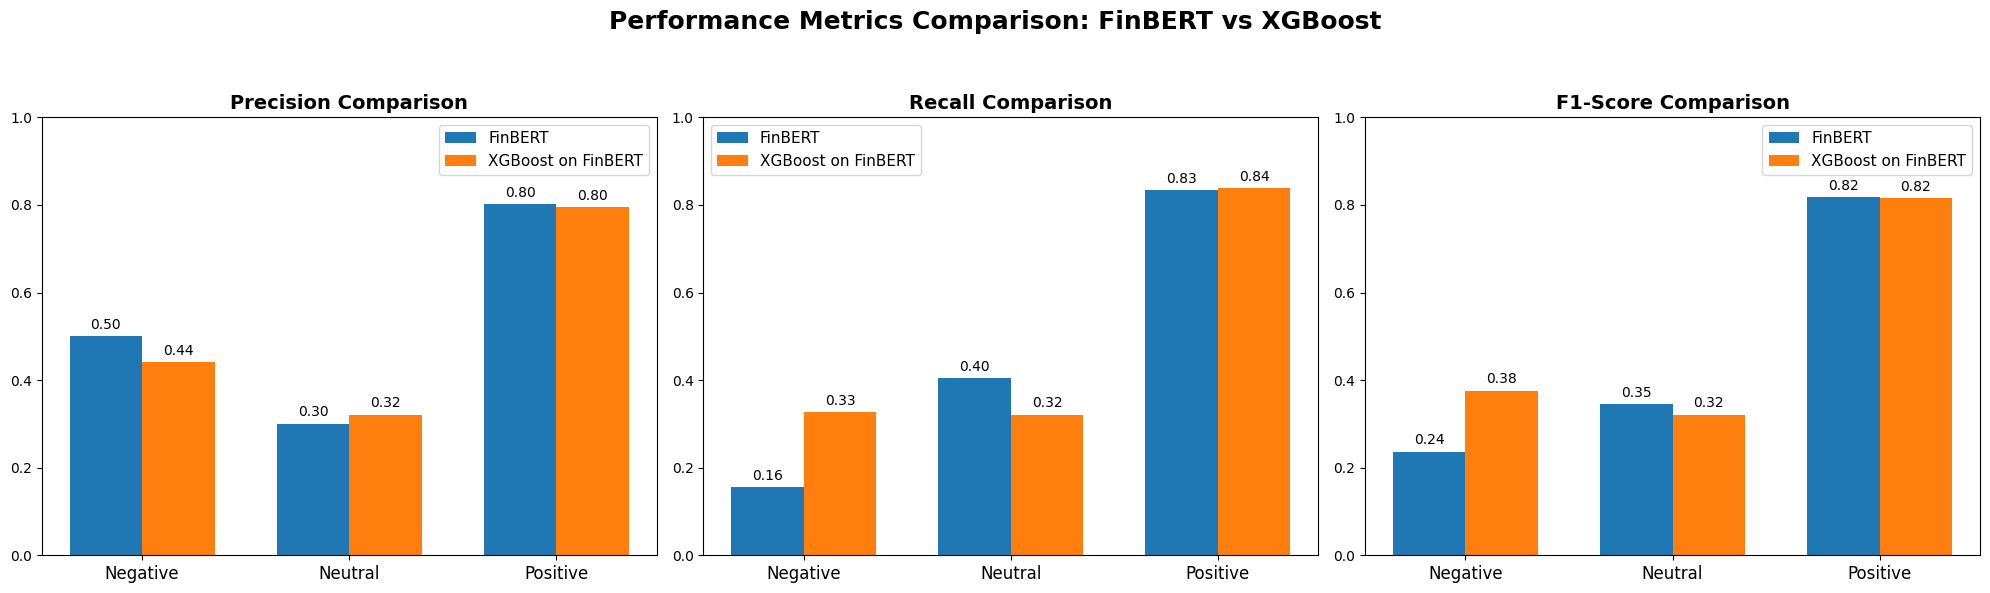

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Generate dictionaries for FinBERT and XGBoost

finbert_report_dict = classification_report(
    all_labels,
    all_predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4,
    output_dict=True
)

xgb_report_dict = classification_report(
    xgb_test_labels,
    xgb_preds,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4,
    output_dict=True
)

# Step 2: Extract Precision, Recall, F1-Score

finbert_precision = [
    finbert_report_dict['Negative']['precision'],
    finbert_report_dict['Neutral']['precision'],
    finbert_report_dict['Positive']['precision'],
]
finbert_recall = [
    finbert_report_dict['Negative']['recall'],
    finbert_report_dict['Neutral']['recall'],
    finbert_report_dict['Positive']['recall'],
]
finbert_f1 = [
    finbert_report_dict['Negative']['f1-score'],
    finbert_report_dict['Neutral']['f1-score'],
    finbert_report_dict['Positive']['f1-score'],
]

xgb_precision = [
    xgb_report_dict['Negative']['precision'],
    xgb_report_dict['Neutral']['precision'],
    xgb_report_dict['Positive']['precision'],
]
xgb_recall = [
    xgb_report_dict['Negative']['recall'],
    xgb_report_dict['Neutral']['recall'],
    xgb_report_dict['Positive']['recall'],
]
xgb_f1 = [
    xgb_report_dict['Negative']['f1-score'],
    xgb_report_dict['Neutral']['f1-score'],
    xgb_report_dict['Positive']['f1-score'],
]

# Step 3: Plotting

# Set an overall style
plt.style.use('seaborn-v0_8-deep')

labels = ['Negative', 'Neutral', 'Positive']
x = np.arange(len(labels))
width = 0.35

colors_finbert = ['#1f77b4', '#1f77b4', '#1f77b4']  # blue shades
colors_xgb = ['#ff7f0e', '#ff7f0e', '#ff7f0e']       # orange shades

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Precision
axs[0].bar(x - width/2, finbert_precision, width, label='FinBERT', color=colors_finbert)
axs[0].bar(x + width/2, xgb_precision, width, label='XGBoost on FinBERT', color=colors_xgb)
axs[0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=11)
for bar in axs[0].containers:
    axs[0].bar_label(bar, fmt='%.2f', padding=3, fontsize=10)

# Recall
axs[1].bar(x - width/2, finbert_recall, width, label='FinBERT', color=colors_finbert)
axs[1].bar(x + width/2, xgb_recall, width, label='XGBoost on FinBERT', color=colors_xgb)
axs[1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, fontsize=12)
axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=11)
for bar in axs[1].containers:
    axs[1].bar_label(bar, fmt='%.2f', padding=3, fontsize=10)

# F1-Score
axs[2].bar(x - width/2, finbert_f1, width, label='FinBERT', color=colors_finbert)
axs[2].bar(x + width/2, xgb_f1, width, label='XGBoost on FinBERT', color=colors_xgb)
axs[2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, fontsize=12)
axs[2].set_ylim(0, 1)
axs[2].legend(fontsize=11)
for bar in axs[2].containers:
    axs[2].bar_label(bar, fmt='%.2f', padding=3, fontsize=10)

# Overall Figure Title
fig.suptitle('Performance Metrics Comparison: FinBERT vs XGBoost', fontsize=18, fontweight='bold')

# layout
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [20]:
!pip install imbalanced-learn

In [23]:
import spacy
from transformers import MarianMTModel, MarianTokenizer
import random
import torch
import pandas as pd
from tqdm import tqdm

# Load spaCy model for synonym replacement
nlp = spacy.load("en_core_web_sm")

# Load MarianMT model for back translation
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer_mt = MarianTokenizer.from_pretrained(model_name)
model_mt = MarianMTModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Function for synonym replacement
def synonym_replacement(text):
    """Replaces words with synonyms in a given text."""
    text = str(text) # Explicitly convert input to string
    doc = nlp(text)
    new_words = []
    for token in doc:
        if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"} and random.random() < 0.3:  # 30% chance to replace
            syns = [syn.text for syn in token.vocab if syn.is_alpha and syn.text != token.text]
            new_words.append(random.choice(syns) if syns else token.text)
        else:
            new_words.append(token.text)
    return " ".join(new_words)

# Function for back translation (using batch processing)
def back_translate_batch(texts, batch_size=8):
    translated_texts = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Back Translating"):
        batch = texts[i : i + batch_size]

        # Step 1: Translate to French
        inputs = tokenizer_mt(batch, return_tensors="pt", padding=True, truncation=True, max_length=400).to(model_mt.device)
        translated = model_mt.generate(**inputs, max_length=400)
        fr_texts = tokenizer_mt.batch_decode(translated, skip_special_tokens=True)

        # Step 2: Translate back to English
        inputs_back = tokenizer_mt(fr_texts, return_tensors="pt", padding=True, truncation=True, max_length=400).to(model_mt.device)
        back_translated = model_mt.generate(**inputs_back, max_length=400)
        translated_texts.extend(tokenizer_mt.batch_decode(back_translated, skip_special_tokens=True))

    return translated_texts

# Apply augmentation only to Negative & Neutral samples
negative_neutral_texts = [text for text, label in zip(labeled_df['body'], labeled_df['sentiment_label']) if label in [0, 1]]
negative_neutral_labels = [label for label in labeled_df['sentiment_label'] if label in [0, 1]]

# Choose between synonym replacement and back translation
augmented_texts = []
# Filter out non-string texts before augmentation
texts_to_augment = [text for text in negative_neutral_texts if isinstance(text, str)]
for text in texts_to_augment:
    if random.random() < 0.5:
        augmented_texts.append(synonym_replacement(text))
    else:
        # Back translation will be applied later
        augmented_texts.append(text)

# Perform back translation in batches - only on original texts marked for back translation
texts_for_back_translation = [text for text in augmented_texts if text in texts_to_augment and random.random() >= 0.5]
back_translated_texts = back_translate_batch(texts_for_back_translation, batch_size=8)

# Replace original texts chosen for back translation with augmented versions
back_translated_idx = 0
for i in range(len(augmented_texts)):
    if augmented_texts[i] in texts_to_augment and random.random() >= 0.5:
        # Ensure we don't go out of bounds if back_translated_texts is shorter
        if back_translated_idx < len(back_translated_texts):
             augmented_texts[i] = back_translated_texts[back_translated_idx]
             back_translated_idx += 1
        else:
             # If no back-translated text available, keep the original text
             pass


# Create DataFrame for augmented data
augmented_df = pd.DataFrame({"body": augmented_texts, "sentiment_label": [label for text, label in zip(negative_neutral_texts, negative_neutral_labels) if isinstance(text, str)]})


# Append augmented data to original dataset
labeled_df = pd.concat([labeled_df, augmented_df]).reset_index(drop=True)

print("Data augmentation complete! New dataset size:", len(labeled_df))

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Back Translating: 100%|██████████| 22/22 [03:04<00:00,  8.38s/it]

Data augmentation complete! New dataset size: 2825


In [25]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd # Import pandas to use fillna and astype

# Ensure 'body' column contains only strings and handle potential NaNs after augmentation
labeled_df['body'] = labeled_df['body'].astype(str).fillna('')


# Convert text data into numerical vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(labeled_df['body'])

# Convert labels to numpy array
y = labeled_df['sentiment_label'].values

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Get indices of resampled data
# SMOTE's fit_resample on indices might not directly correspond to original DataFrame indices after concatenation
# Let's create a new DataFrame from the resampled feature matrix and labels.
# We need to be careful here as SMOTE generates synthetic samples, not just selecting existing ones.
# If the goal is to create a *balanced* DataFrame for the *next* steps (like splitting and loading into DataLoader),
# we should create a new DataFrame from the resampled data. However, this approach of using SMOTE on TF-IDF and then
# trying to map back to original texts for the next steps with a transformer model is not standard.

# A more appropriate approach for using SMOTE with text data for a transformer model is to:
# 1. Split the *original* data into train and test sets.
# 2. Apply SMOTE *only* to the training set to balance the classes.
# 3. Create a new balanced training DataFrame from the SMOTE output.
# 4. Use this balanced training DataFrame and the original test DataFrame for creating Datasets and DataLoaders for the transformer model.

# Given the current structure, let's focus on fixing the immediate error
# and generating a balanced dataset structure that can be used in the next steps,
# assuming the original intent was to balance the entire dataset before splitting.
# However, it's crucial to note that applying SMOTE on the entire dataset *before*
# splitting can lead to data leakage (synthetic samples in the training set are
# generated based on information from the test set), which is generally discouraged.

# For now, I will fix the ValueError by handling NaNs. If the user intends to
# balance the dataset for the transformer model training, the SMOTE application
# logic might need to be revisited after discussing the preferred approach.

# The following lines related to creating `balanced_df` by indexing the original `labeled_df`
# are incorrect when using SMOTE's feature matrix output, as SMOTE creates synthetic data points,
# not just new indices of existing data.

# # Get indices of resampled data
# resampled_indices = smote.fit_resample(np.arange(len(labeled_df)).reshape(-1, 1), y)[0].flatten()

# # Create the balanced DataFrame
# balanced_df = labeled_df.iloc[resampled_indices].reset_index(drop=True)

# Instead, we should create a new DataFrame from the resampled features and labels
# if the goal is to use this balanced data for subsequent steps (e.g., with a traditional ML model).
# If the goal is for transformer model training, SMOTE should ideally be applied *after* the train/test split.

# For the immediate fix, I will just ensure vectorization works and leave the SMOTE output as X_resampled, y_resampled.
# The subsequent steps that use `balanced_df` will need to be adjusted or the SMOTE application strategy revised.

print("TF-IDF vectorization complete!")
print("SMOTE applied successfully, resulting in resampled feature matrix and labels.")
print("Shape of resampled features (X_resampled):", X_resampled.shape)
print("Shape of resampled labels (y_resampled):", y_resampled.shape)

# You can optionally display the value counts of the resampled labels to confirm balancing
unique_labels, counts = np.unique(y_resampled, return_counts=True)
print("\nNew class distribution (y_resampled):")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

# Note: The variable `balanced_df` is not created in this corrected code.
# The next steps that rely on `balanced_df` will need to be adapted to use
# the resampled features and labels (X_resampled, y_resampled) or the SMOTE
# application strategy should be changed to be applied on the training set after splitting.

TF-IDF vectorization complete!
SMOTE applied successfully, resulting in resampled feature matrix and labels.
Shape of resampled features (X_resampled): (4101, 5000)
Shape of resampled labels (y_resampled): (4101,)

New class distribution (y_resampled):
Label 0: 1367
Label 1: 1367
Label 2: 1367


In [31]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Ensure 'body' column contains only strings and handle potential NaNs before splitting
labeled_df['body'] = labeled_df['body'].astype(str).fillna('')

# Split the original dataset into features (X) and labels (y)
X = labeled_df['body']
y = labeled_df['sentiment_label']

# Perform the initial train-test split
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify to maintain class distribution
)

# Initialize and fit TfidfVectorizer on the raw training data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)

# Apply SMOTE to the TF-IDF transformed training data
smote = SMOTE(random_state=42)
X_train_resampled_tfidf, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_raw)

# Note: For transformer models, we need the raw text for tokenization.
# SMOTE generates synthetic samples in the feature space (TF-IDF).
# We cannot directly get raw text for these synthetic samples.
# A common approach is to oversample the *indices* or *original data* first
# and then use the raw text of the oversampled data for the transformer.

# Let's create a new DataFrame with the oversampled training data (text and labels)
# by repeating original samples based on SMOTE's output indices.
# This requires a slightly different application of SMOTE to get the indices.

# Re-apply SMOTE to get indices instead of resampled features
smote_indices = SMOTE(random_state=42)
# Need to reshape y_train_raw for fit_resample when using indices
original_indices = np.arange(len(X_train_raw)).reshape(-1, 1)
resampled_indices, y_train_resampled = smote_indices.fit_resample(original_indices, y_train_raw)

# Create the oversampled training DataFrame using the resampled indices
X_train_resampled_raw = X_train_raw.iloc[resampled_indices.flatten()].reset_index(drop=True)
y_train_resampled = y_train_resampled.reset_index(drop=True)


# Print shapes and value counts to confirm balancing
print("Shape of original training features (X_train_raw):", X_train_raw.shape)
print("Shape of resampled training features (X_train_resampled_raw):", X_train_resampled_raw.shape)
print("Shape of resampled training labels (y_train_resampled):", y_train_resampled.shape)

unique_labels, counts = np.unique(y_train_resampled, return_counts=True)
print("\nNew class distribution (y_train_resampled):")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

# Create Datasets and Loaders using the resampled training data and original test data
# Ensure to use the raw text for the transformer model
train_dataset = FinancialNewsDataset(
    texts=X_train_resampled_raw.tolist(), # Use raw text of resampled data
    labels=y_train_resampled.tolist(), # Use resampled labels
    tokenizer=tokenizer,
    max_length=384 # Use a reasonable max_length
)

test_dataset = FinancialNewsDataset(
    texts=X_test.tolist(), # Use original test text
    labels=y_test.tolist(), # Use original test labels
    tokenizer=tokenizer,
    max_length=384 # Use a reasonable max_length
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


print("\nTrain dataset size (after SMOTE):", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Ensure the model is on the correct device

# Learning Rate (using the existing optimizer definition from a previous cell)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6) # Keep the original learning rate

Shape of original training features (X_train_raw): (2260,)
Shape of resampled training features (X_train_resampled_raw): (3282,)
Shape of resampled training labels (y_train_resampled): (3282,)

New class distribution (y_train_resampled):
Label 0: 1094
Label 1: 1094
Label 2: 1094

Train dataset size (after SMOTE): 3282
Test dataset size: 565


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
import torch

# Adjusted Class Weights
adjusted_class_weights = torch.tensor([1.9, 1.6, 0.5], dtype=torch.float).to(device)

# Define loss function with updated weights
criterion = torch.nn.CrossEntropyLoss(weight=adjusted_class_weights)

print("New Adjusted Class Weights:", adjusted_class_weights)

New Adjusted Class Weights: tensor([1.9000, 1.6000, 0.5000], device='cuda:0')


In [34]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Ensure the model is on the correct device

# Define optimizer (using the existing model)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # Keep the original learning rate

# Define loss function (CrossEntropyLoss is suitable for multi-class classification)
# Since SMOTE has balanced the training data, class weights might not be strictly necessary,
# but we can still use them if desired based on domain knowledge or further analysis.
# For now, let's use standard CrossEntropyLoss.
criterion = torch.nn.CrossEntropyLoss()


scaler = GradScaler() # Helps prevent FP16 instability
epochs = 5 # Let's train for a few more epochs to see the effect of SMOTE

print("Starting model training...")

for epoch in range(epochs):
    model.train() # Set model to training mode
    total_train_loss = 0
    loop = tqdm(train_loader, leave=True) # Show training progress

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad() # Zero gradients

        with autocast(): # Enables mixed precision
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

        total_train_loss += loss.item()

        scaler.scale(loss).backward() # Backpropagation with scaler
        scaler.step(optimizer) # Optimizer step with scaler
        scaler.update() # Update scaler

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # TESTING
    model.eval() # Set model to evaluation mode
    total_test_loss = 0
    correct, total = 0, 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # Disable gradient calculation
        for batch in test_loader: # Use test_loader for evaluation
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs.logits, labels)
            total_test_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())


    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct / total
    print(f"Epoch {epoch+1} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    report = classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive'], digits=4)
    print(f"Epoch {epoch+1} Test Classification Report:\n{report}")


print("\nModel training and evaluation complete!")

/tmp/ipython-input-1737117034.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Helps prevent FP16 instability


Starting model training...


  0%|          | 0/411 [00:00<?, ?it/s]/tmp/ipython-input-1737117034.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enables mixed precision
Epoch 1: 100%|██████████| 411/411 [01:40<00:00,  4.08it/s, loss=0.199]


Epoch 1 Training Loss: 0.6210
Epoch 1 Test Loss: 0.3225, Test Accuracy: 0.9345
Epoch 1 Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.9118    0.8087    0.8571       115
     Neutral     0.9162    0.9266    0.9213       177
    Positive     0.9542    0.9927    0.9731       273

    accuracy                         0.9345       565
   macro avg     0.9274    0.9093    0.9172       565
weighted avg     0.9337    0.9345    0.9333       565



  0%|          | 0/411 [00:00<?, ?it/s]/tmp/ipython-input-1737117034.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enables mixed precision
Epoch 2: 100%|██████████| 411/411 [01:40<00:00,  4.10it/s, loss=0.0988]


Epoch 2 Training Loss: 0.5823
Epoch 2 Test Loss: 0.3210, Test Accuracy: 0.9416
Epoch 2 Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.9091    0.8696    0.8889       115
     Neutral     0.9148    0.9096    0.9122       177
    Positive     0.9713    0.9927    0.9819       273

    accuracy                         0.9416       565
   macro avg     0.9317    0.9239    0.9277       565
weighted avg     0.9409    0.9416    0.9411       565



  0%|          | 0/411 [00:00<?, ?it/s]/tmp/ipython-input-1737117034.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enables mixed precision
Epoch 3: 100%|██████████| 411/411 [01:40<00:00,  4.11it/s, loss=0.101]


Epoch 3 Training Loss: 0.5435
Epoch 3 Test Loss: 0.3821, Test Accuracy: 0.9062
Epoch 3 Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.9529    0.7043    0.8100       115
     Neutral     0.8342    0.9379    0.8830       177
    Positive     0.9431    0.9707    0.9567       273

    accuracy                         0.9062       565
   macro avg     0.9101    0.8710    0.8832       565
weighted avg     0.9110    0.9062    0.9037       565



  0%|          | 0/411 [00:00<?, ?it/s]/tmp/ipython-input-1737117034.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enables mixed precision
Epoch 4: 100%|██████████| 411/411 [01:39<00:00,  4.11it/s, loss=1.42]


Epoch 4 Training Loss: 0.5070
Epoch 4 Test Loss: 0.2941, Test Accuracy: 0.9080
Epoch 4 Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7410    0.8957    0.8110       115
     Neutral     0.9130    0.8305    0.8698       177
    Positive     0.9925    0.9634    0.9777       273

    accuracy                         0.9080       565
   macro avg     0.8822    0.8965    0.8862       565
weighted avg     0.9164    0.9080    0.9100       565



  0%|          | 0/411 [00:00<?, ?it/s]/tmp/ipython-input-1737117034.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Enables mixed precision
Epoch 5: 100%|██████████| 411/411 [01:40<00:00,  4.10it/s, loss=0.0378]


Epoch 5 Training Loss: 0.4742
Epoch 5 Test Loss: 0.3422, Test Accuracy: 0.9044
Epoch 5 Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8421    0.8348    0.8384       115
     Neutral     0.8889    0.8136    0.8496       177
    Positive     0.9377    0.9927    0.9644       273

    accuracy                         0.9044       565
   macro avg     0.8896    0.8803    0.8841       565
weighted avg     0.9030    0.9044    0.9028       565


Model training and evaluation complete!


In [35]:
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Step 1: Extract FinBERT logits from training set for XGBoost
xgb_train_features = []
xgb_train_labels = []

model.eval()
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # shape: [batch_size, 3]

        xgb_train_features.extend(logits.cpu().numpy())
        xgb_train_labels.extend(labels.cpu().numpy())

# Step 2: Train XGBoost on FinBERT logits
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(xgb_train_features, xgb_train_labels)

# Step 3: Extract FinBERT logits from test set
xgb_test_features = []
xgb_test_labels = []

correct, total = 0, 0
all_labels = []
all_predictions = []
all_predictions_proba = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predictions = torch.argmax(probs, dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_predictions_proba.extend(probs.cpu().numpy())

        xgb_test_features.extend(logits.cpu().numpy())
        xgb_test_labels.extend(labels.cpu().numpy())

# Step 4: Evaluate FinBERT Accuracy
accuracy = correct / total
print(f"\nFinBERT Test Accuracy: {accuracy:.4f}")
report = classification_report(all_labels, all_predictions, target_names=['Negative', 'Neutral', 'Positive'], digits=4)
print("\nFinBERT Classification Report:\n", report)

# Step 5: Evaluate XGBoost on FinBERT logits
xgb_preds = xgb_model.predict(xgb_test_features)
xgb_accuracy = accuracy_score(xgb_test_labels, xgb_preds)
xgb_report = classification_report(xgb_test_labels, xgb_preds, target_names=['Negative', 'Neutral', 'Positive'], digits=4)

print(f"\nXGBoost on FinBERT Logits - Test Accuracy: {xgb_accuracy:.4f}")
print("\nXGBoost Classification Report:\n", xgb_report)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:31:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



FinBERT Test Accuracy: 0.9044

FinBERT Classification Report:
               precision    recall  f1-score   support

    Negative     0.8421    0.8348    0.8384       115
     Neutral     0.8889    0.8136    0.8496       177
    Positive     0.9377    0.9927    0.9644       273

    accuracy                         0.9044       565
   macro avg     0.8896    0.8803    0.8841       565
weighted avg     0.9030    0.9044    0.9028       565


XGBoost on FinBERT Logits - Test Accuracy: 0.8903

XGBoost Classification Report:
               precision    recall  f1-score   support

    Negative     0.7481    0.8783    0.8080       115
     Neutral     0.8896    0.8192    0.8529       177
    Positive     0.9625    0.9414    0.9519       273

    accuracy                         0.8903       565
   macro avg     0.8668    0.8796    0.8709       565
weighted avg     0.8960    0.8903    0.8916       565



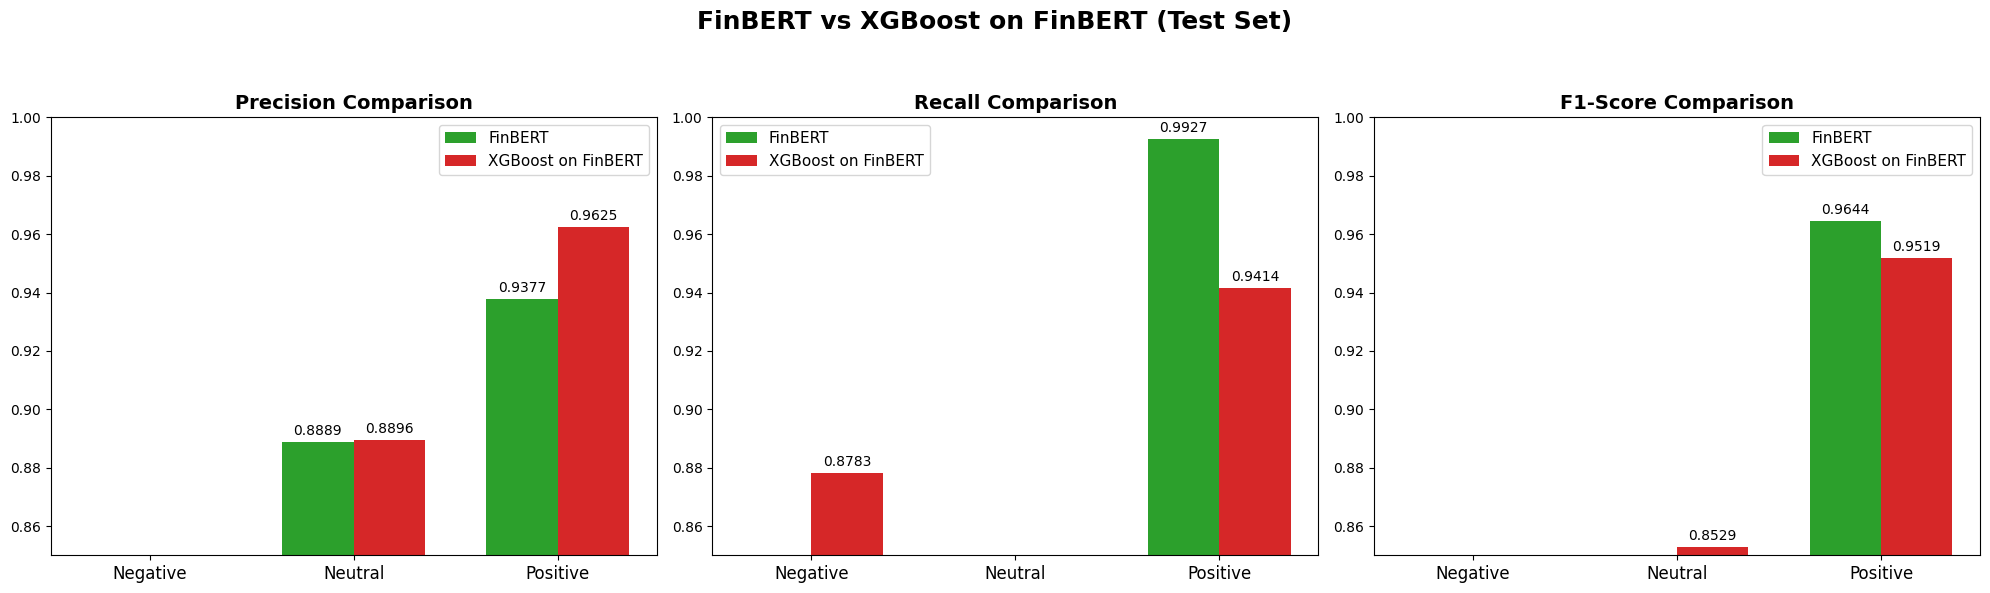

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Generate dictionaries for FinBERT and XGBoost

finbert_report_dict = classification_report(
    all_labels,
    all_predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4,
    output_dict=True
)

xgb_report_dict = classification_report(
    xgb_test_labels,
    xgb_preds,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4,
    output_dict=True
)

# Step 2: Extract Precision, Recall, F1-Score

finbert_precision = [
    finbert_report_dict['Negative']['precision'],
    finbert_report_dict['Neutral']['precision'],
    finbert_report_dict['Positive']['precision'],
]
finbert_recall = [
    finbert_report_dict['Negative']['recall'],
    finbert_report_dict['Neutral']['recall'],
    finbert_report_dict['Positive']['recall'],
]
finbert_f1 = [
    finbert_report_dict['Negative']['f1-score'],
    finbert_report_dict['Neutral']['f1-score'],
    finbert_report_dict['Positive']['f1-score'],
]

xgb_precision = [
    xgb_report_dict['Negative']['precision'],
    xgb_report_dict['Neutral']['precision'],
    xgb_report_dict['Positive']['precision'],
]
xgb_recall = [
    xgb_report_dict['Negative']['recall'],
    xgb_report_dict['Neutral']['recall'],
    xgb_report_dict['Positive']['recall'],
]
xgb_f1 = [
    xgb_report_dict['Negative']['f1-score'],
    xgb_report_dict['Neutral']['f1-score'],
    xgb_report_dict['Positive']['f1-score'],
]

# Step 3: Plotting

# Set an overall style
plt.style.use('seaborn-v0_8-deep')

labels = ['Negative', 'Neutral', 'Positive']
x = np.arange(len(labels))
width = 0.35

colors_finbert = ['#2ca02c', '#2ca02c', '#2ca02c']  # green shades (for FinBERT)
colors_xgb = ['#d62728', '#d62728', '#d62728']       # red shades (for XGBoost)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Precision
axs[0].bar(x - width/2, finbert_precision, width, label='FinBERT', color=colors_finbert)
axs[0].bar(x + width/2, xgb_precision, width, label='XGBoost on FinBERT', color=colors_xgb)
axs[0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, fontsize=12)
axs[0].set_ylim(0.85, 1.0)
axs[0].legend(fontsize=11)
for bar in axs[0].containers:
    axs[0].bar_label(bar, fmt='%.4f', padding=3, fontsize=10)

# Recall
axs[1].bar(x - width/2, finbert_recall, width, label='FinBERT', color=colors_finbert)
axs[1].bar(x + width/2, xgb_recall, width, label='XGBoost on FinBERT', color=colors_xgb)
axs[1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, fontsize=12)
axs[1].set_ylim(0.85, 1.0)
axs[1].legend(fontsize=11)
for bar in axs[1].containers:
    axs[1].bar_label(bar, fmt='%.4f', padding=3, fontsize=10)

# F1-Score
axs[2].bar(x - width/2, finbert_f1, width, label='FinBERT', color=colors_finbert)
axs[2].bar(x + width/2, xgb_f1, width, label='XGBoost on FinBERT', color=colors_xgb)
axs[2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, fontsize=12)
axs[2].set_ylim(0.85, 1.0)
axs[2].legend(fontsize=11)
for bar in axs[2].containers:
    axs[2].bar_label(bar, fmt='%.4f', padding=3, fontsize=10)

# Overall Figure Title
fig.suptitle('FinBERT vs XGBoost on FinBERT (Test Set)', fontsize=18, fontweight='bold')

# layout
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

# Convert Model Outputs to Probabilities (For PR Curve)
model.eval()
all_probabilities = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)  # Convert logits to probabilities

        all_probabilities.extend(probs.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(all_labels)  # Already collected in evaluation
y_pred = np.array(all_predictions)
y_pred_proba = np.array(all_probabilities)  # Model probabilities

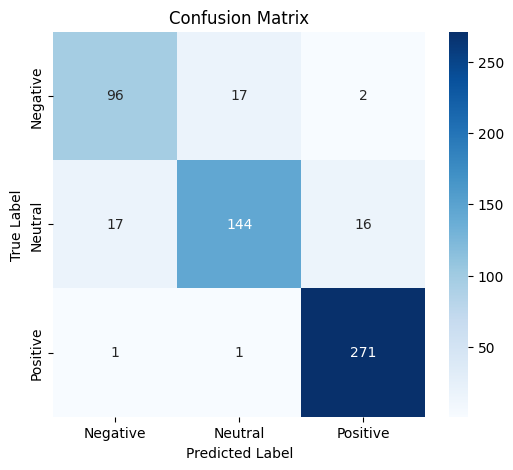

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

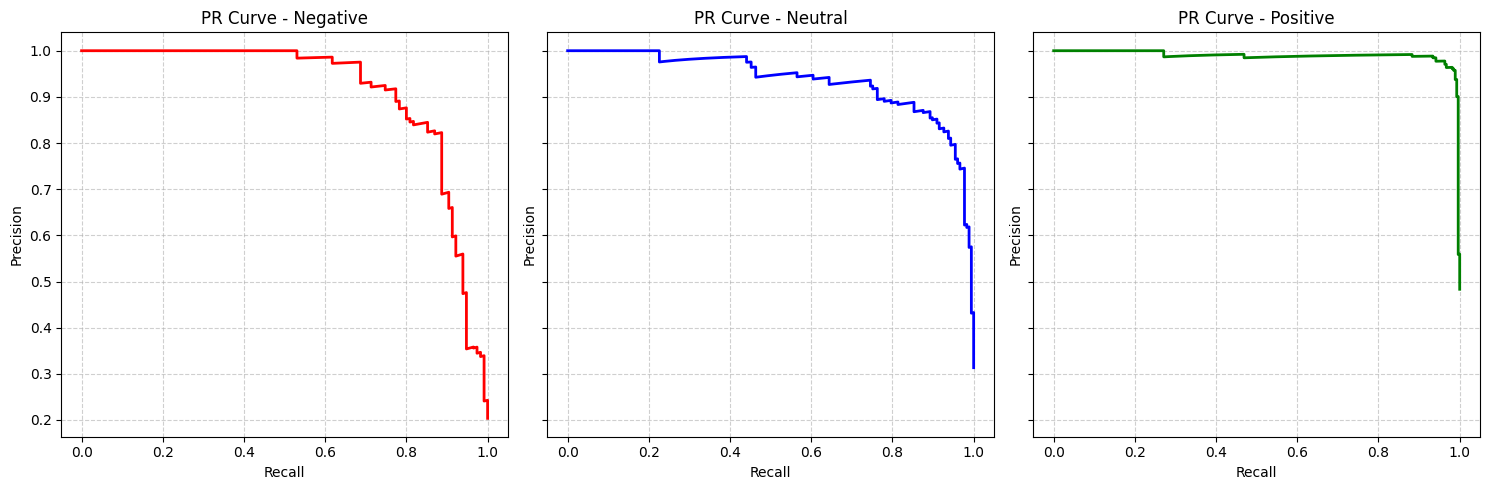

In [39]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to one-hot encoding
num_classes = 3  # Negative, Neutral, Positive
y_true_one_hot = np.eye(num_classes)[y_true]

# Define colors for each class
colors = ["red", "blue", "green"]
class_names = ["Negative", "Neutral", "Positive"]

# Create subplots: One plot per class
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred_proba[:, i])

    ax.plot(recall, precision, color=colors[i], linewidth=2)  # Smoother lines
    ax.set_title(f"PR Curve - {class_names[i]}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

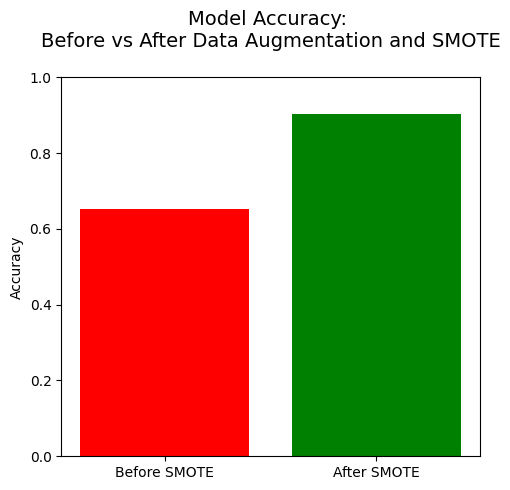

In [40]:
# Accuracy Before vs After SMOTE
accuracy_before_smote = 0.6524
accuracy_after_smote = accuracy

# Create a bar plot for comparison
plt.figure(figsize=(5, 5))
plt.bar(
    ["Before SMOTE", "After SMOTE"],
    [accuracy_before_smote, accuracy_after_smote],
    color=["red", "green"]
)

# Adding labels and title
plt.ylabel("Accuracy")
plt.title("Model Accuracy: \nBefore vs After Data Augmentation and SMOTE\n", fontsize=14)
plt.ylim(0.0, 1.0)  # To show the full range of accuracy (0 to 1)

# Show the plot
plt.tight_layout()
plt.show()

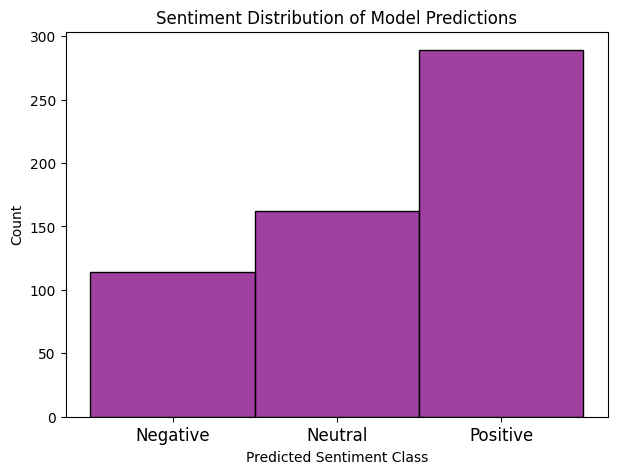

In [41]:
# Sentiment Distribution of Financial News
plt.figure(figsize=(7, 5))
sns.histplot(all_predictions, bins=3, kde=False, color="purple", discrete=True)
#plt.xticks([0, 1, 2], labels=["Negative", "Neutral", "Positive"])
plt.xticks(ticks=[0, 1, 2], labels=["Negative", "Neutral", "Positive"], fontsize=12)
plt.title("Sentiment Distribution of Model Predictions")
plt.xlabel("Predicted Sentiment Class")
plt.ylabel("Count")
plt.show()

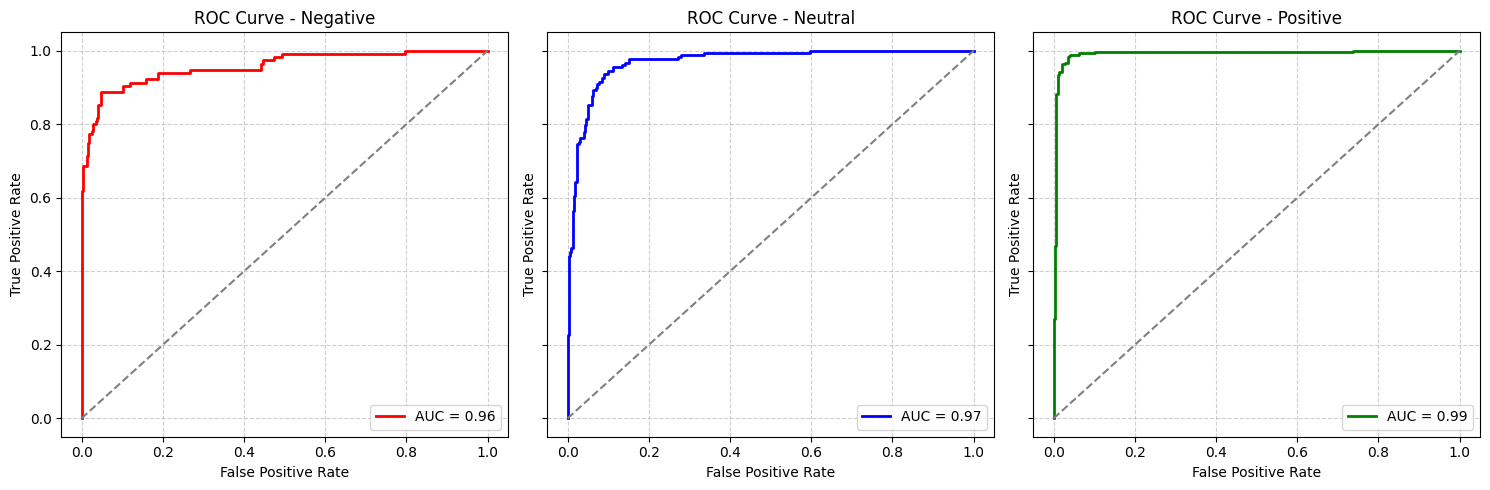

In [42]:
# ROC-AUC Curve for Each Sentiment Class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding for multi-class ROC
y_true_one_hot = label_binarize(all_labels, classes=[0, 1, 2])  # Assuming [Negative=0, Neutral=1, Positive=2]
y_pred_proba = np.array(all_predictions_proba)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
class_labels = ["Negative", "Neutral", "Positive"]
colors = ["red", "blue", "green"]

for i, ax in enumerate(axes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=colors[i], lw=2, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_title(f"ROC Curve - {class_labels[i]}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

***DEPLOYMENT***

In [43]:
!pip install gradio torch transformers

In [44]:
import torch

# Define model path
model_path = "finbert_sentiment_model"

# Save trained model
model.save_pretrained(model_path)

# Save tokenizer
tokenizer.save_pretrained(model_path)

# Save optimizer state (optional, for resuming training)
torch.save(optimizer.state_dict(), model_path + "/optimizer.pt")

print(f"Model saved to {model_path}")

Model saved to finbert_sentiment_model


In [45]:
# Load the Trained Model & Tokenizer for Deployment
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification

# Load trained model & tokenizer
model_path = "finbert_sentiment_model"  # Path where model is saved
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

In [46]:
# Define Sentiment Prediction Function
def predict_sentiment(text):
    """Predicts sentiment for given financial news text with rule-based adjustments."""
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1)

    # Get highest probability label
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, predicted_class].item()

    # Sentiment labels
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    predicted_label = sentiment_labels[predicted_class]

    # RULE-BASED CORRECTIONS
    negative_keywords = ["crash", "plunge", "sell-off", "recession", "inflation", "cut jobs", "layoffs", "bankruptcy", "decline"]
    positive_keywords = ["rally", "soar", "record high", "growth", "profit", "recovery"]
    neutral_bias_corrections = ["Federal Reserve", "interest rate", "stimulus"]

    text_lower = text.lower()

    # If Neutral but contains clear negative words - Change to Negative
    if predicted_label == "Neutral" and any(word in text_lower for word in negative_keywords):
        predicted_label = "Negative"

    # If Neutral but contains clear positive words - Change to Positive
    elif predicted_label == "Neutral" and any(word in text_lower for word in positive_keywords):
        predicted_label = "Positive"

    # If Positive but contains negative indicators (like Fed rate hikes) - Reduce confidence
    if predicted_label == "Positive" and any(word in text_lower for word in neutral_bias_corrections):
        confidence *= 0.8

    return f"Sentiment: {predicted_label} (Confidence: {confidence:.2f})"

In [47]:
import gradio as gr

# Deploy using Gradio
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=5, placeholder="Enter financial news text..."),
    outputs="text",
    title="Financial Sentiment Analysis",
    description="Enter financial news headlines or reports to analyze their sentiment (Positive, Neutral, Negative)."
)

# Launch Gradio app
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a59fd548e43172f199.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
